In [99]:
from scipy.io.arff import loadarff
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np


pd.set_option("display.max_columns", None)

IRIS_CLASSES = ["Setosa", "Versicolour", "Virginica"]

sns.set_style("darkgrid")


# Zaczytanie zbiorów IRIS, Polish Companies Bankruptcy

In [3]:
attributes_file = open("data/labels.txt")

attributes = [attr.strip().split(" ")[0].strip() for attr in attributes_file]
attributes_dict = {}
for index, attribute in enumerate(attributes):
    attributes_dict[f"Attr{index + 1}"] = attribute

dframes = []
for year in range(1, 6):
    data = loadarff(f"data/{year}year.arff")
    df = pd.DataFrame(data[0])
    df = df.rename(attributes_dict, axis="columns")
    dframes.append(df)


def map_classes(x):
    cls = str(x["class"]).strip()
    if cls == "b'0'":
        return 0
    if cls == "b'1'":
        return 1
    raise Exception(f"Unexpected class {cls}")


global_df = pd.concat(dframes)

global_df["class"] = global_df.apply(map_classes, axis=1)


In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_df_X, iris_y = load_iris(return_X_y=True, as_frame=True)
bankruptcy_df_X, bakruptcy_y = (
    global_df.loc[:, global_df.columns != "class"],
    global_df[["class"]],
)

iris_X_train, iris_y_train, iris_X_test, iris_y_test = train_test_split(
    iris_df_X, iris_y, test_size=0.2, random_state=10, shuffle=True, stratify=iris_y
)


In [80]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_df_X, iris_y = load_iris(return_X_y=True, as_frame=True)
bankruptcy_df_X, bankruptcy_y = (
    global_df.loc[:, global_df.columns != "class"],
    global_df[["class"]],
)

iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris_df_X, iris_y, test_size=0.2, random_state=10, shuffle=True, stratify=iris_y
)


# FORCE_TRAIN_SIZE = 6000
# FORCE_TEST_SIZE = 600

FORCE_TRAIN_SIZE = 3000
FORCE_TEST_SIZE = 300

(
    bankruptcy_X_train,
    bankruptcy_X_test,
    bankruptcy_y_train,
    bankruptcy_y_test,
) = train_test_split(
    bankruptcy_df_X,
    bankruptcy_y,
    train_size=FORCE_TRAIN_SIZE,
    test_size=FORCE_TEST_SIZE,
    random_state=20,
    shuffle=True,
    stratify=bankruptcy_y,
)
print("Bankruptcy - proportion of classes in train and test dataset")
display(bankruptcy_y_train.groupby("class").size())
display(bankruptcy_y_test.groupby("class").size())


class
0    2855
1     145
dtype: int64

class
0    286
1     14
dtype: int64

In [81]:
def create_pipeline_for_bankruptcy(**kwargs):
    return Pipeline(
        [
            ("imputation", KNNImputer(n_neighbors=3)),
            ("clf", DecisionTreeClassifier(**kwargs)),
        ]
    )


Pipeline(steps=[('imputation', KNNImputer(n_neighbors=3)),
                ('clf', DecisionTreeClassifier())])

# Uruchomienie algorytmu drzewa decyzyjnego dla IRIS dla domyślnych parametrów.

In [6]:
clf = DecisionTreeClassifier()

clf.fit(X=iris_X_train, y=iris_y_train)


DecisionTreeClassifier()

# Wizualizacja drzewa i analiza jakości klasyfikacji wynikowego drzewa decyzyjnego.

/tmp/ipykernel_4336/1289096998.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


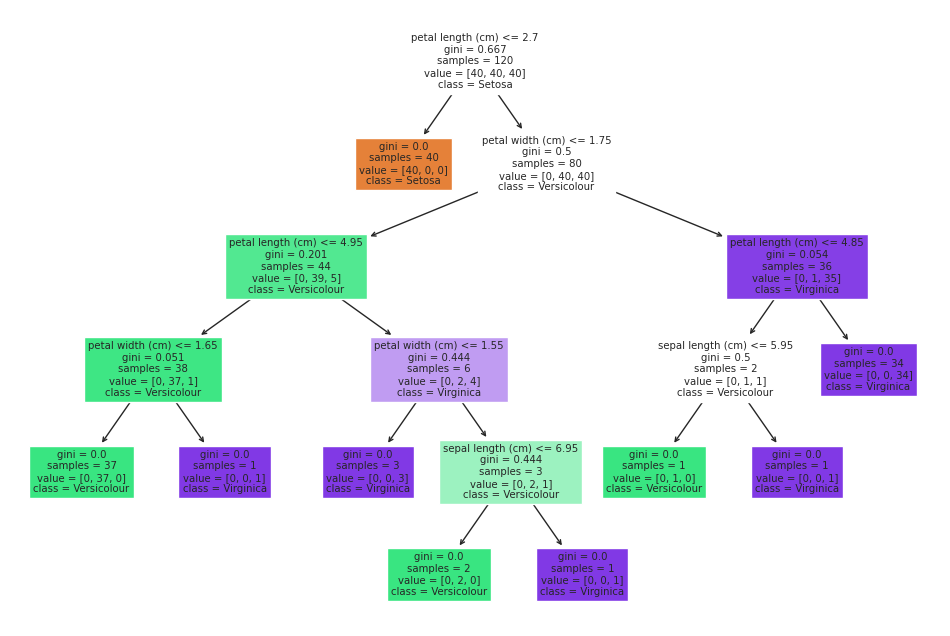

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plot_tree(
    clf,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax,
    filled=True,
)
fig.show()


/tmp/ipykernel_4336/869033614.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


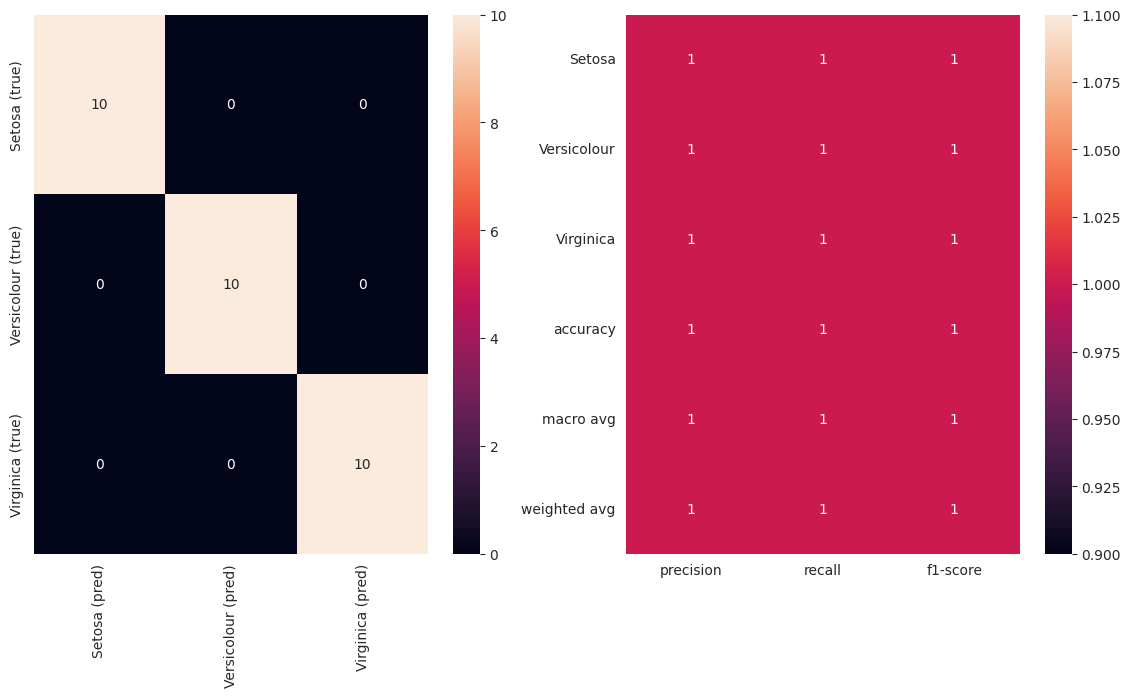

In [8]:
y_pred = clf.predict(iris_X_test)

cf_matrix = confusion_matrix(iris_y_test, y_pred)

fig, ax = plt.subplots(ncols=2)
sns.heatmap(
    cf_matrix,
    annot=True,
    ax=ax[0],
    xticklabels=[cla + " (pred)" for cla in IRIS_CLASSES],
    yticklabels=[cla + " (true)" for cla in IRIS_CLASSES],
)

clf_report = classification_report(
    iris_y_test, y_pred, target_names=IRIS_CLASSES, output_dict=True
)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax[1])
fig.set_size_inches(14, 7)
fig.show()


# Wstępne strojenie algorytmów dla zbiorów - IRIS

In [92]:
search = GridSearchCV(
    clf,
    param_grid={
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [1, 2, 3, 4, 5, 6, 7],
        "min_samples_leaf": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        "ccp_alpha": [
            0.0,
            0.02,
            0.04,
            0.06,
            0.08,
            0.1,
            0.12,
            0.14,
            0.16,
            0.18,
            0.20,
            0.40,
            0.60,
            0.80,
        ],
    },
    n_jobs=-1,
)

search.fit(iris_df_X, iris_y)


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12,
                                       0.14, 0.16, 0.18, 0.2, 0.4, 0.6, 0.8],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                                              0.3]})

In [93]:
results = pd.DataFrame(search.cv_results_)

results = results.loc[
    :,
    [
        "param_ccp_alpha",
        "param_criterion",
        "param_max_depth",
        "param_min_samples_leaf",
        "mean_test_score",
        "rank_test_score",
    ],
]

print("Best result - IRIS")
best_params_iris = results.sort_values(by="rank_test_score").head(1)
display(best_params_iris)


Best result - IRIS


,param_ccp_alpha,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,rank_test_score
14,0.0,gini,3,0.01,0.96,1


# Wizualizacja drzew dla różnych hiperparametrów - IRIS

/tmp/ipykernel_4336/3758139387.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_4336/3758139387.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


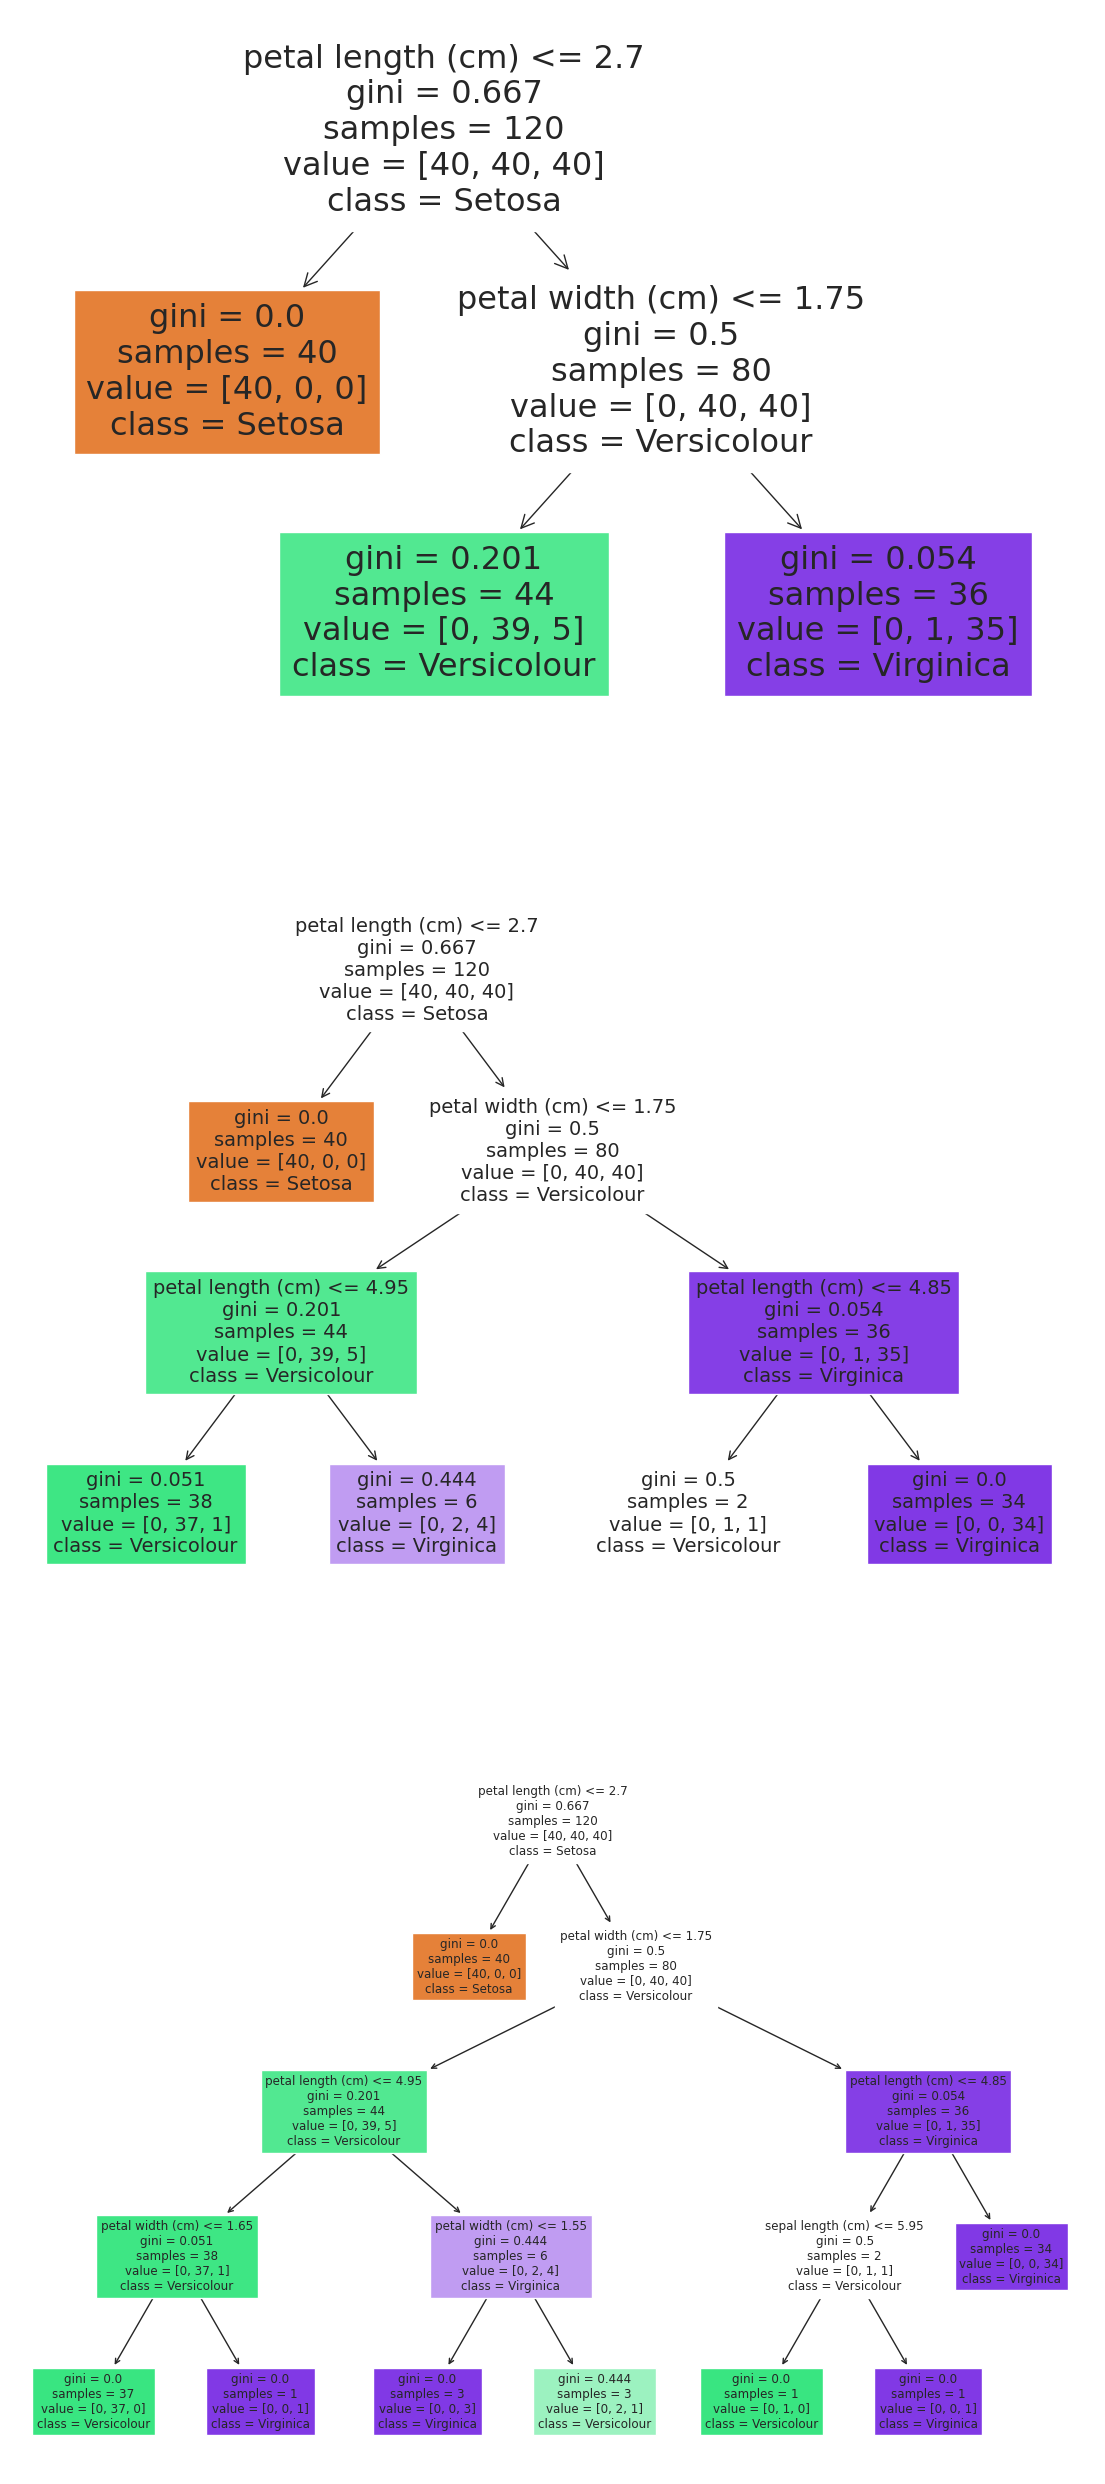

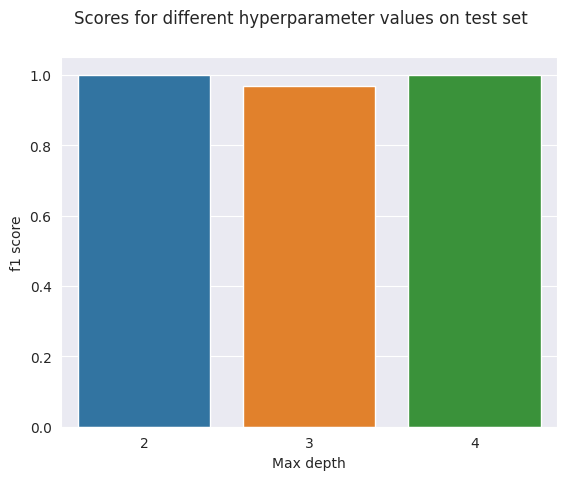

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=1)

fig.set_size_inches(14, 32)

clf1 = DecisionTreeClassifier(max_depth=2).fit(iris_X_train, iris_y_train)
clf2 = DecisionTreeClassifier(max_depth=3).fit(iris_X_train, iris_y_train)
clf3 = DecisionTreeClassifier(max_depth=4).fit(iris_X_train, iris_y_train)

plot_tree(
    clf1,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[0],
    filled=True,
)
plot_tree(
    clf2,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[1],
    filled=True,
)
plot_tree(
    clf3,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[2],
    filled=True,
)

fig.show()

fig, ax = plt.subplots()
data = pd.DataFrame(
    [
        [
            f1_score(iris_y_test, clf1.predict(iris_X_test), average="weighted"),
            f1_score(iris_y_test, clf2.predict(iris_X_test), average="weighted"),
            f1_score(iris_y_test, clf3.predict(iris_X_test), average="weighted"),
        ]
    ],
    columns=[2, 3, 4],
)

sns.barplot(ax=ax, data=data)
ax.set_xlabel("Max depth")
ax.set_ylabel("f1 score")
fig.suptitle("Scores for different hyperparameter values on test set")
fig.show()


/tmp/ipykernel_4336/1490635887.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_4336/1490635887.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


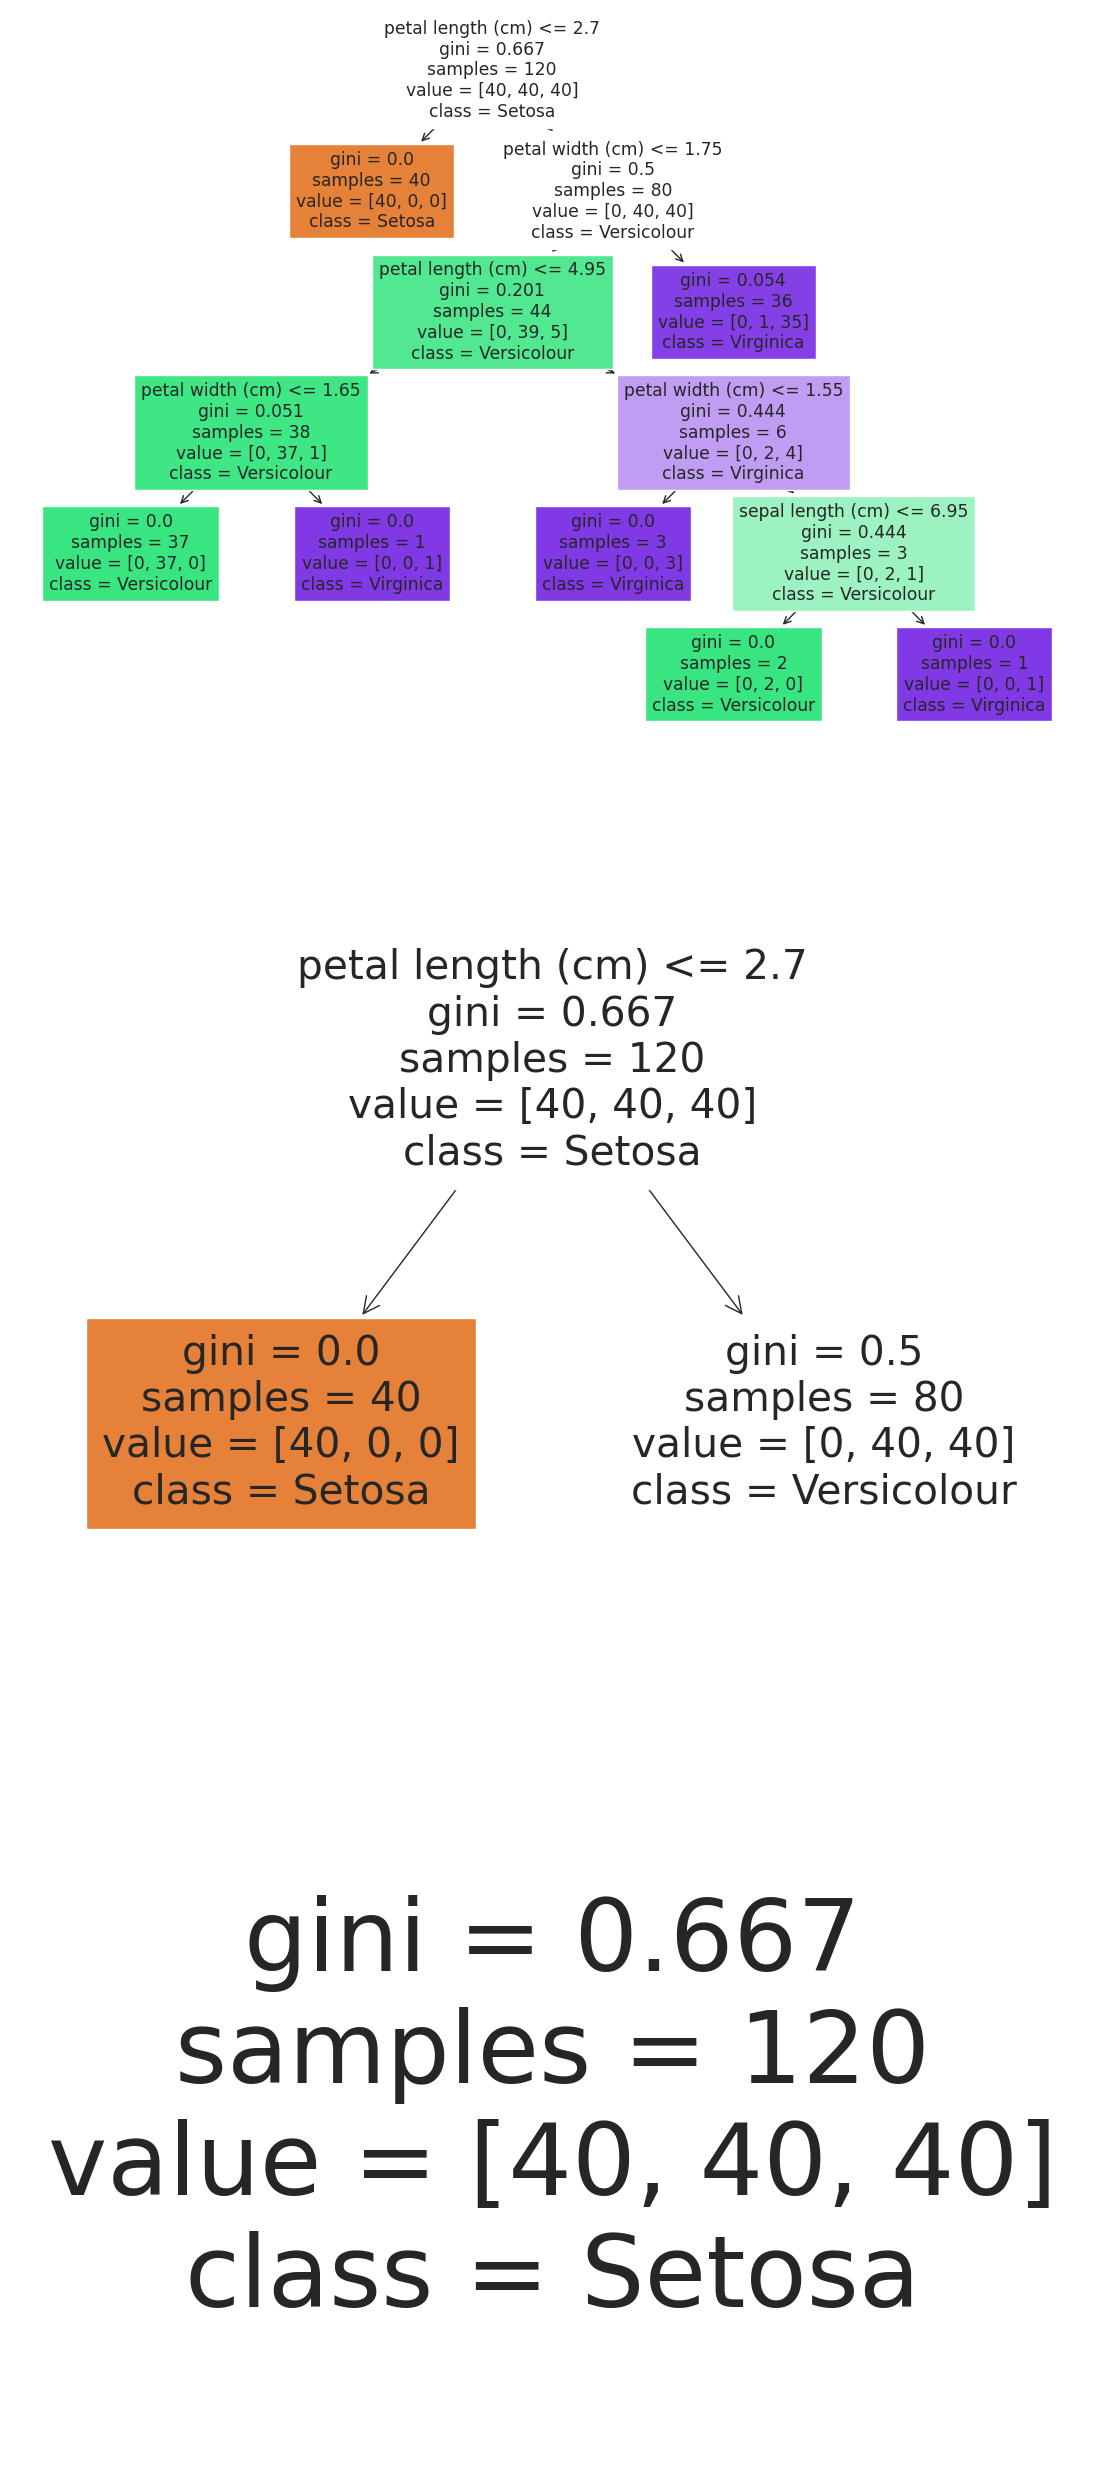

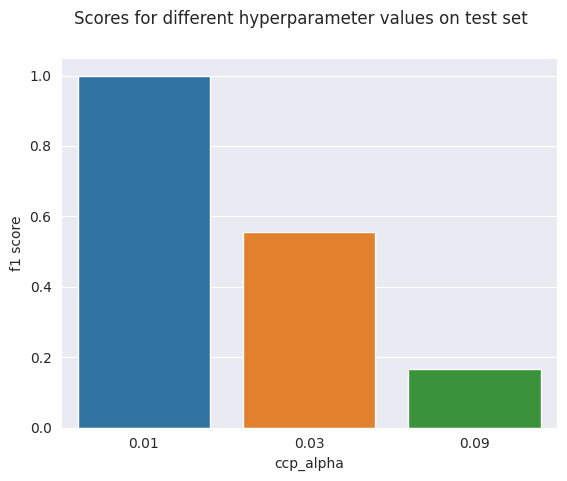

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=1)

fig.set_size_inches(14, 32)
clf1 = DecisionTreeClassifier(ccp_alpha=0.01).fit(iris_X_train, iris_y_train)
clf2 = DecisionTreeClassifier(ccp_alpha=0.25).fit(iris_X_train, iris_y_train)
clf3 = DecisionTreeClassifier(ccp_alpha=0.4).fit(iris_X_train, iris_y_train)

plot_tree(
    clf1,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[0],
    filled=True,
)
plot_tree(
    clf2,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[1],
    filled=True,
)
plot_tree(
    clf3,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[2],
    filled=True,
)

fig.show()

fig, ax = plt.subplots()
data = pd.DataFrame(
    [
        [
            f1_score(iris_y_test, clf1.predict(iris_X_test), average="weighted"),
            f1_score(iris_y_test, clf2.predict(iris_X_test), average="weighted"),
            f1_score(iris_y_test, clf3.predict(iris_X_test), average="weighted"),
        ]
    ],
    columns=["0.01", "0.03", "0.09"],
)

sns.barplot(ax=ax, data=data)
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("f1 score")
fig.suptitle("Scores for different hyperparameter values on test set")
fig.show()


/tmp/ipykernel_4336/1517538506.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_4336/1517538506.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


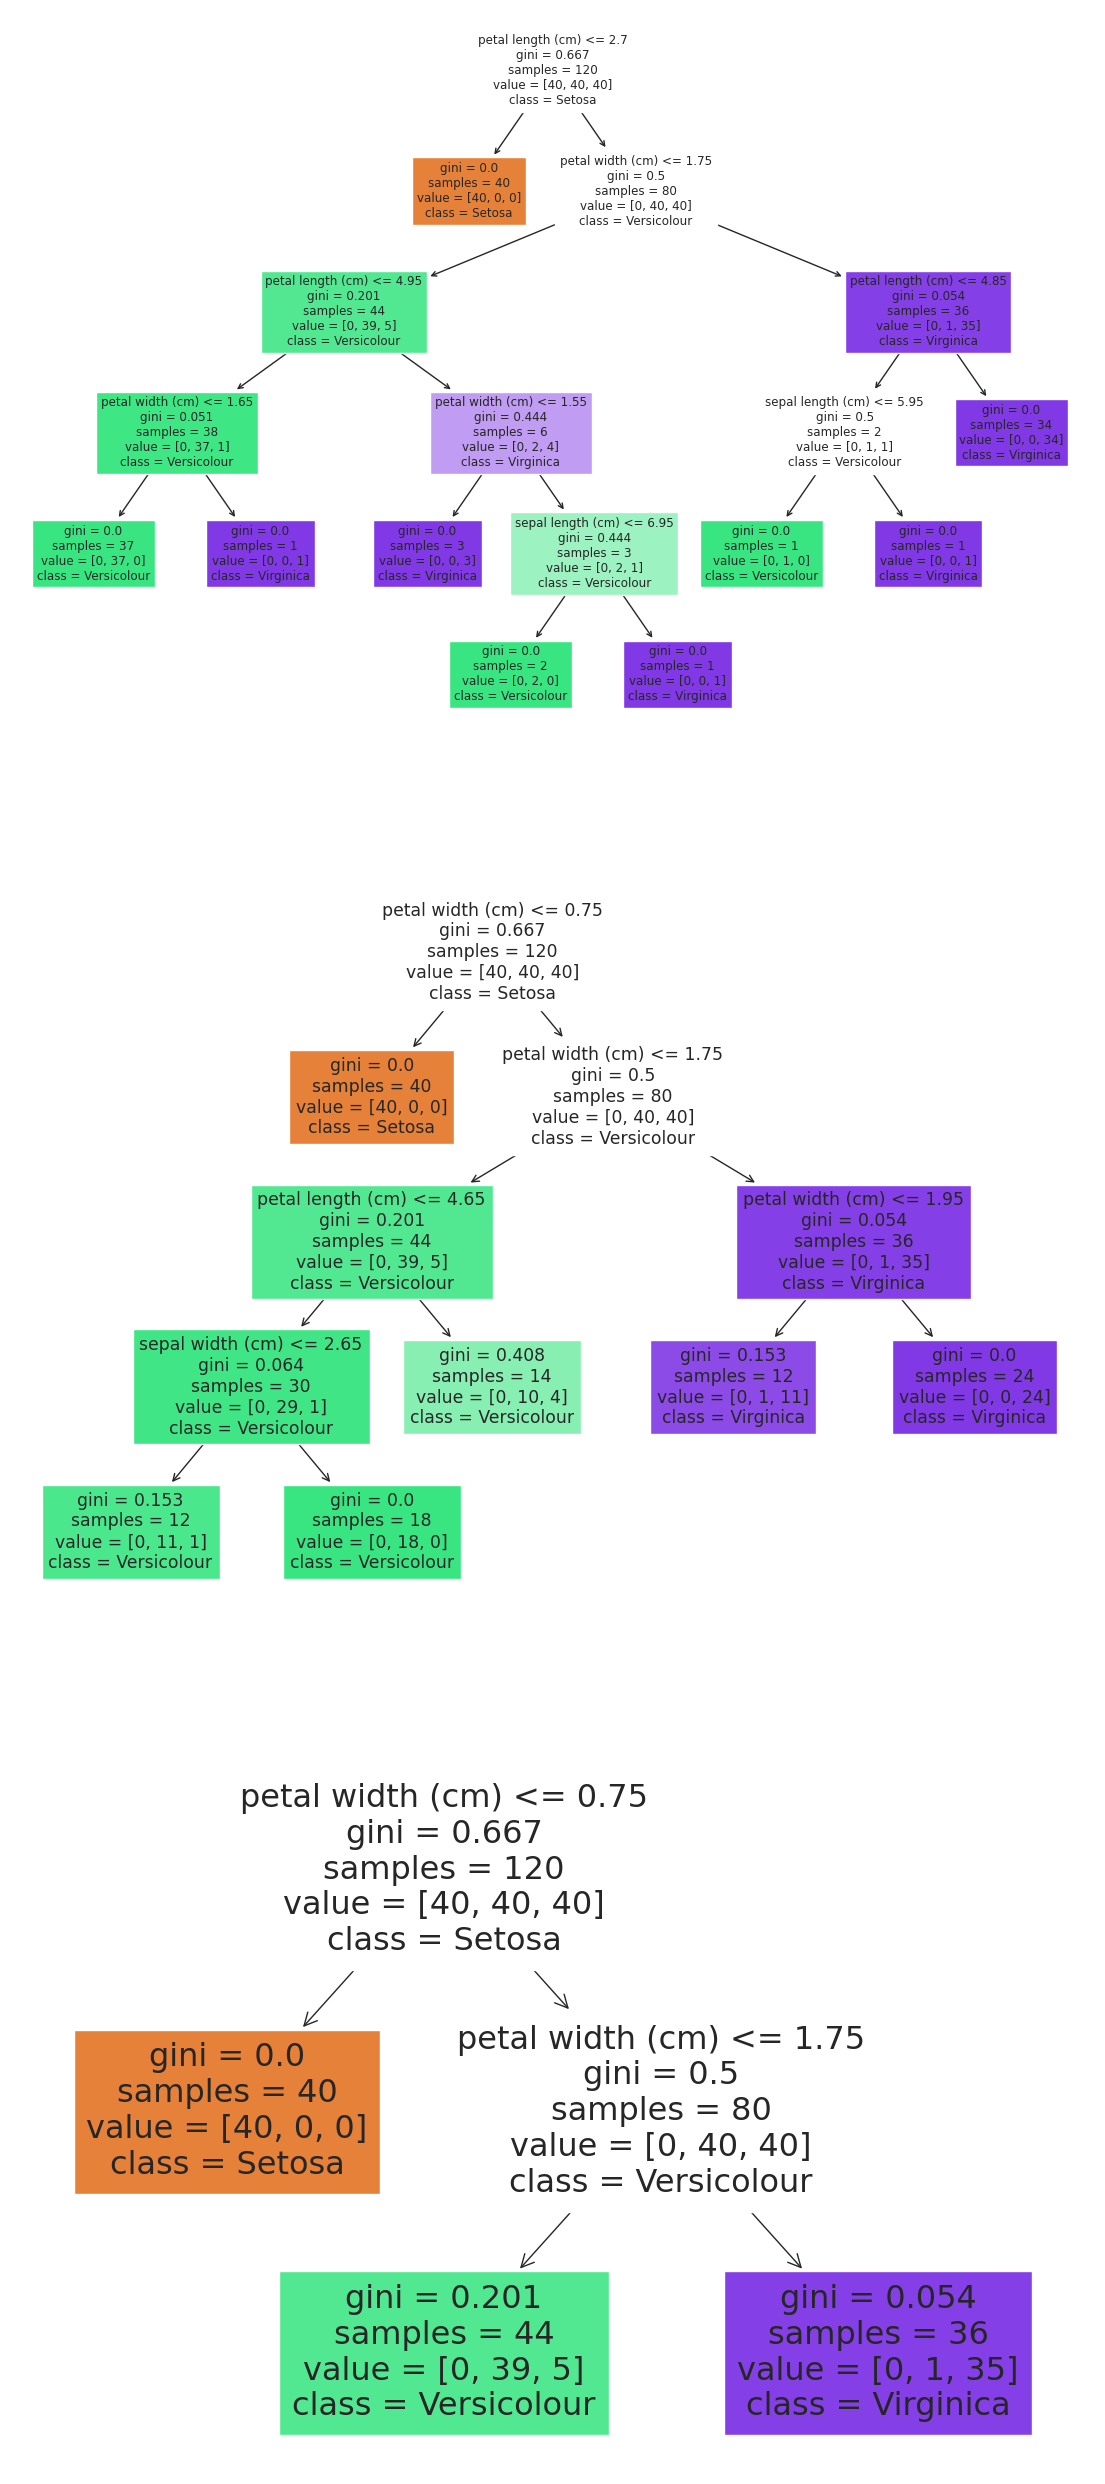

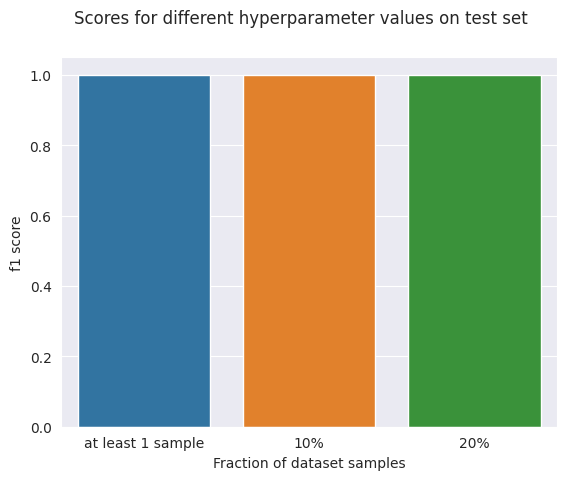

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=1)

fig.set_size_inches(14, 32)

clf1 = DecisionTreeClassifier(min_samples_leaf=1).fit(iris_X_train, iris_y_train)
clf2 = DecisionTreeClassifier(min_samples_leaf=0.1).fit(iris_X_train, iris_y_train)
clf3 = DecisionTreeClassifier(min_samples_leaf=0.2).fit(iris_X_train, iris_y_train)
plot_tree(
    clf1,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[0],
    filled=True,
)
plot_tree(
    clf2,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[1],
    filled=True,
)
plot_tree(
    clf3,
    feature_names=iris_X_train.columns,
    class_names=IRIS_CLASSES,
    ax=ax[2],
    filled=True,
)

fig.show()

fig, ax = plt.subplots()
data = pd.DataFrame(
    [
        [
            f1_score(iris_y_test, clf1.predict(iris_X_test), average="weighted"),
            f1_score(iris_y_test, clf2.predict(iris_X_test), average="weighted"),
            f1_score(iris_y_test, clf3.predict(iris_X_test), average="weighted"),
        ]
    ],
    columns=["at least 1 sample", "10%", "20%"],
)

sns.barplot(ax=ax, data=data)
ax.set_xlabel("Fraction of dataset samples")
ax.set_ylabel("f1 score")
fig.suptitle("Scores for different hyperparameter values on test set")
fig.show()


# Użycie walidacji krzyżowej (zwykłej oraz stratyfikowanej).

In [107]:
no_stratified = cross_val_score(
    DecisionTreeClassifier(
        criterion=best_params_iris["param_criterion"].values[0],
        ccp_alpha=best_params_iris["param_ccp_alpha"].values[0],
        max_depth=best_params_iris["param_max_depth"].values[0],
        min_samples_leaf=best_params_iris["param_min_samples_leaf"].values[0],
    ),
    iris_df_X,
    iris_y,
    n_jobs=-1,
    cv=KFold(5),
    scoring="f1_weighted",
)

stratified = cross_val_score(
    DecisionTreeClassifier(
        criterion=best_params_iris["param_criterion"].values[0],
        ccp_alpha=best_params_iris["param_ccp_alpha"].values[0],
        max_depth=best_params_iris["param_max_depth"].values[0],
        min_samples_leaf=best_params_iris["param_min_samples_leaf"].values[0],
    ),
    iris_df_X,
    iris_y,
    n_jobs=-1,
    cv=StratifiedKFold(5),
    scoring="f1_weighted",
)
print("IRIS")
print(f"no stratification = {np.average(no_stratified)}")
print(f"with stratification = {np.average(stratified)}")


IRIS
no stratification = 0.9379708011286958
with stratification = 0.9596972228551175


# Użycie parametru wagi klasy (class_weight) oraz analiza wyników

In [108]:
no_stratified = cross_val_score(
    DecisionTreeClassifier(
        criterion=best_params_iris["param_criterion"].values[0],
        ccp_alpha=best_params_iris["param_ccp_alpha"].values[0],
        max_depth=best_params_iris["param_max_depth"].values[0],
        min_samples_leaf=best_params_iris["param_min_samples_leaf"].values[0],
        class_weight=None,
    ),
    iris_df_X,
    iris_y,
    n_jobs=-1,
    cv=StratifiedKFold(5),
    scoring="f1_weighted",
)

stratified = cross_val_score(
    DecisionTreeClassifier(
        criterion=best_params_iris["param_criterion"].values[0],
        ccp_alpha=best_params_iris["param_ccp_alpha"].values[0],
        max_depth=best_params_iris["param_max_depth"].values[0],
        min_samples_leaf=best_params_iris["param_min_samples_leaf"].values[0],
        class_weight="balanced",
    ),
    iris_df_X,
    iris_y,
    n_jobs=-1,
    cv=StratifiedKFold(5),
    scoring="f1_weighted",
)
print("IRIS")
print(f"no balancing = {np.average(no_stratified)}")
print(f"with balancing = {np.average(stratified)}")


IRIS
no balancing = 0.9462292093871041
with balancing = 0.9596972228551175


# Wnioski - TODO